#Frank-Wolfe for semi-relaxed optimal transport

*Alberto Rossetto, Cècile Obeid*

#Imports

In [1]:
import numpy as np
import time
from matplotlib.image import imread
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
np.random.seed(0)

# Optimal Transport

The Optimal Transport(OT) problem seeks an optimal transport plan or transport matrix by solving the total minimum transport from source to destination. OT problem requires solution of linear programming with tight mass-conservation constraints. To alleviate this issue, it is advisable to use relaxed-OT approach that uses a faster algorithm by relaxing such constraints. In particular, in some application like color transfering where wights and mass need not to be preserved, the constraint-relaxed approach has gained great success. 

## Color transfer problem

This experimet addresses the OT-based color transfer problem. Given two images that have three dimension of RGB, we first extract image features of the images using k-means algorithm. After executing k-means with a predefined number of classes, all the pixels in the image are assiged into each class. Averaging all the pixel values assigned in each class yields weight vectors, the centroids. By following the procedure, we obtain m color centroids $x_1,x_2,x_3,...,x_m \in \mathbb{R^3}$. Additionally, we obtain a color histogram $a \in \Delta_{m}$ by counting of the assigned pixels for m classes. Similary, n color centroids $y_1,y_2,y_3,...,y_n \in \mathbb{R^3}$ and $b \in \Delta_{n}$.

# Images

In [3]:
from google.colab import files

uploaded = files.upload()

Saving boris_small.jpg to boris_small.jpg
Saving minesota_small.jpg to minesota_small.jpg


In [4]:
source = 'boris_small.jpg' #SOURCE
target = 'minesota_small.jpg' #REFERENCE

In [5]:
def load_image_to_vector(fname):
  img = imread(fname)
  plt.imshow(img)
  img_vector = img.reshape(-1, img.shape[-1])
  return img, img_vector

##Source

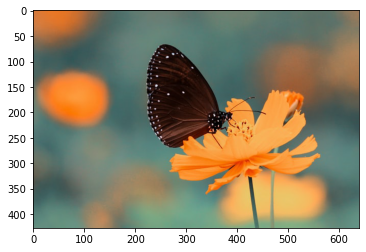

In [6]:
source_img, source_vector = load_image_to_vector(source)

## Reference

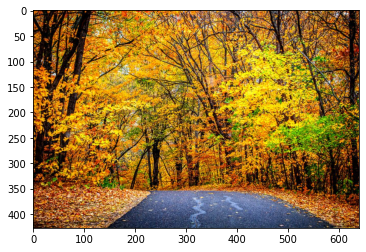

In [7]:
target_img, target_vector = load_image_to_vector(target)

#K-means

In [8]:
def compute_KMeans(data, n_clusters):
  n_samples = data.shape[0]

  kmeans = KMeans(n_clusters = n_clusters)
  s = kmeans.fit(data)

  labels = list(s.labels_)
  centroids = s.cluster_centers_

  percent=[]
  for i in range(len(centroids)):
    j = labels.count(i)
    j = j/(len(labels))
    percent.append(j)

  percent = np.array(percent)

  return centroids, np.array(labels), percent

In [9]:
x_centroids, x_labels, a = compute_KMeans(source_vector, 32)

In [10]:
np.sum(a)

0.9999999999999999

In [11]:
y_centroids, y_labels, b = compute_KMeans(target_vector, 32)

In [12]:
np.sum(b)

1.0

#Objective function

The semi-relaxed problem of interest is formally defined as 
$$ \min_{\substack{T \geqslant0 \\ T^T1_{m}=b}} \{ f(T) := \langle T,C \rangle + \frac{1}{2\lambda}||T1_{n} - a||^2_2 \}$$
where $\lambda$ is a relaxation parameter. 


In [13]:
def compute_objective_function(T, C, lambda_c, a):
  first_term = np.trace(T.T@C)
  arg = np.dot(T, np.ones(T.shape[1])) - a
  second_term = (1/(2*lambda_c)) * (np.linalg.norm(arg, ord = 2)**2)

  return first_term, second_term, first_term + second_term

## Gradient



The gradient $\nabla f(T) \in \mathbb{R^{mn}}$ is given as 
$$ 
\nabla f(T)=\left[\begin{array}{c}
c_1\\
\vdots \\
c_i\\
\vdots \\
c_n 
\end{array}\right]  + 
\frac{1}{\lambda}
\left[\begin{array}{c}
T1_n - a\\
\vdots \\
T1_n - a\\
\vdots \\
T1_n - a
\end{array}\right] 
$$ 
where the $\nabla f_{i}(T) = c_i + \frac{1}{\lambda}(T1_n - a) \in \mathbb{R^m}  $

# Cost matrix C

The cost matrix C is calculated as $$C_{i,j} = ||x_i - y_j||_2 $$

In [14]:
def compute_cost_matrix(x,y):
  '''
    Compute the cost matrix C as described in section 5.1
  '''

  C = np.zeros(shape = (x.shape[0], y.shape[0]))

  for i in range(0, x.shape[0]):
    for j in range(0, y.shape[0]):
      C[i,j] = np.linalg.norm(x[i] - y[j], ord = 2) 

  return C

In [15]:
C = compute_cost_matrix(x_centroids, y_centroids)

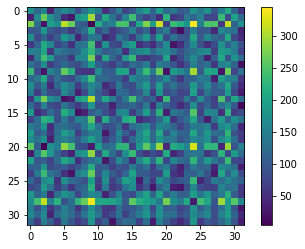

In [16]:
plt.imshow(C)
plt.colorbar()
plt.show()

# Initial transport matrix

The algorithms are initialized from the same initialization point $T_0$, of which first row is set $b$. 


In [17]:
T_0 = np.zeros([a.shape[0], b.shape[0]])
T_0[0, :] = b

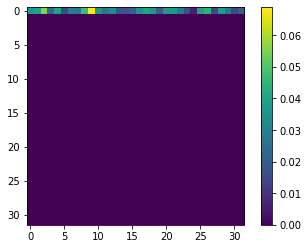

In [18]:
plt.imshow(T_0)
plt.colorbar()
plt.show()

# Frank Wolfe

The Frank Wolfe (FW) algorithm is a constraint convex optimization method. It is known to be a linear approximation algorithm that uses conditional gradient. At every iteration, the feasisble point $s$ is found first by minimizing the linearization of f over the convex feasible set $\mathcal{M}$. To find the feasible point $s$, we solve the following subproblem $$ s=arg \min_{s' \in \mathcal{M}} \langle s', ∇ f(x^{(k)}) \rangle $$
In the equation, $x^{(k)}$ represents the k-th current point. Because the domain $\mathcal{M}$ is the convex set and the objective function is linear for $s$. Finally, the next iterate $x^{(k+1)}$ is obtained by a convex conbination as $x^{(k+1)} = (1-\gamma)x^{(k)} + \gamma s$, where $\gamma$ is the stepsize.

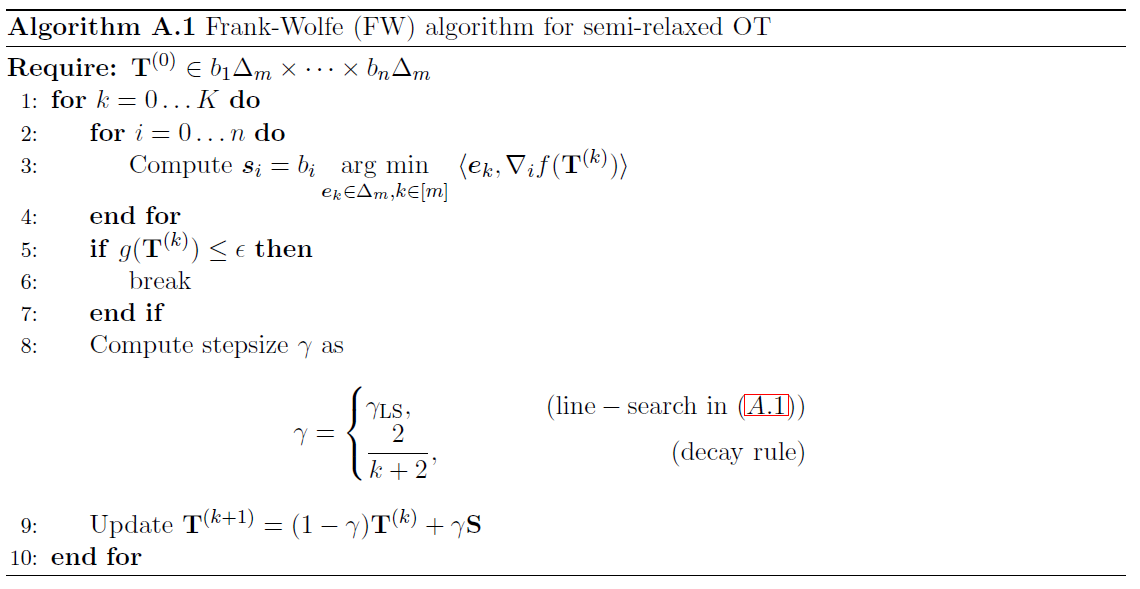

The optimal stepsize $\gamma LS $ is calculated as 
$$ \gamma LS = \frac{\lambda \langle T^{(k)} - S, C \rangle_{F} + \langle T^{(k)}1_n - S1_n, T^{(k)}1_n - a \rangle}{|| T^{(k)}1_n - S1_n ||^2 } $$

In [28]:
def FrankWolfe(T, C, a, b, K, lambda_c, dec):

  '''
  T: Transport matrix | shape = (m,n)
  C: Cost matrix | shape = (m,n)
  a: mass vector
  b: mass vector
  K: number of iterations
  lambda_c: relaxation parameter
  dec: if True performs the decay step size 
  '''

  def compute_linesearch_FW(T_k, S, C, lambda_c, a):

    Tk_1n = np.dot(T_k, np.ones(T.shape[1]))
    S_1n = np.dot(S, np.ones(T.shape[1]))
    first_term = np.trace((T_k - S).T@C)
    second_term = np.dot((Tk_1n - S_1n) , Tk_1n - a)
    numerator = lambda_c*first_term + second_term
    denominator = np.linalg.norm(Tk_1n - S_1n, ord = 2)**2
    return numerator/denominator


  T_k = T.copy()

  # initialize the matrix S
  S = np.zeros(shape = (T_k.shape[0], T_k.shape[1]))

  first_term_log = []
  second_term_log = []
  f_value_log = []
  time_values = [] 


  start_time = time.time()
  time_values.append(0)
  first_term, second_term, f_value = compute_objective_function(T_k, C, lambda_c, a)
  first_term_log.append(first_term)
  second_term_log.append(second_term)
  f_value_log.append(f_value)


  for k in range(0, K):
    for i in range(0,T_k.shape[1]):

      # gradient of block i
      grad_i = C[:,i] + 1/lambda_c * (np.dot(T_k, np.ones(T_k.shape[1])) - a) # vector of shape (m x 1)

      # find the index of the minimal element of the gradient of the variable block
      index = np.argmin(grad_i)

      # create the canonical standard unit vector
      e_j = np.zeros(shape = T_k.shape[0]) 
      e_j[index] = 1.0
    
      # compute s_i
      S[:,i] = np.dot(b[i], e_j)

    # Step-size computation 
    if dec:
      gamma = 2/(k + 2)
    
    else:
      # Exact line search
      gamma = compute_linesearch_FW(T_k, S, C, lambda_c, a)

    # Update T_k
    T_k = (1 - gamma)*T_k + gamma*S

    first_term, second_term, f_value = compute_objective_function(T_k, C, lambda_c, a)
    time_values.append(time.time() - start_time)
    first_term_log.append(first_term)
    second_term_log.append(second_term)
    f_value_log.append(f_value)


  return T_k, first_term_log, second_term_log, f_value_log, time_values

#Block-Coordinate Frank Wolfe

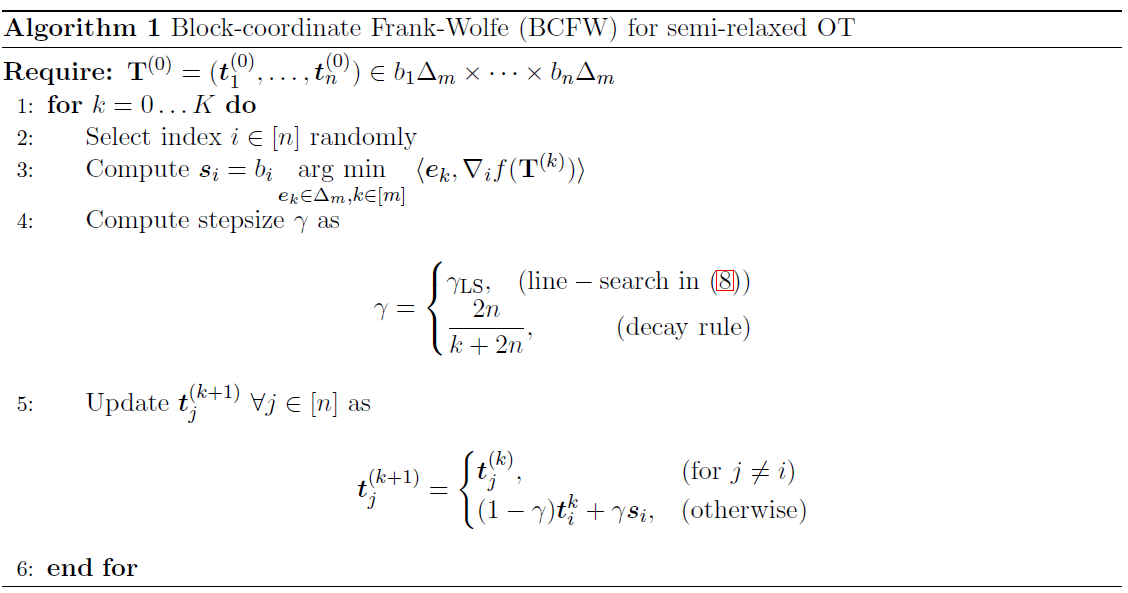

The optimal stepsize $\gamma LS $ is calculated as 
$$ \gamma LS = \frac{\lambda \langle t_i^{(k)} - s_i, c_i \rangle + \langle t_i^{(k)} - s_i, T^{(k)}1_n - a \rangle}{|| t_i^{(k)} - s_i ||^2 } $$

In [21]:
def BlockFrankWolfe(T, C, a, b, K, lambda_c, dec):

  '''
  T: Transport matrix | shape = (m,n)
  C: Cost matrix | shape = (m,n)
  a: mass vector
  b: mass vector
  K: number of iterations
  lambda_c: relaxation parameter
  dec: perform the decay step size (boolean)
  '''

  def compute_linesearch_BCFW(T_k, t_i, s_i, c_i, a, K, lambda_c):

    d = t_i - s_i
    Tk_1n = np.dot(T_k, np.ones(T.shape[1]))
    first_term = np.dot(d, c_i)
    second_term = np.dot(d, (Tk_1n - a))
    numerator = lambda_c*first_term + second_term
    denominator = np.linalg.norm(d, ord = 1)**2
    return numerator/denominator
    
  T_k = T.copy()

  first_term_log = []
  second_term_log = []
  f_value_log = []
  time_values = [] 


  start_time = time.time()
  time_values.append(0)
  first_term, second_term, f_value = compute_objective_function(T_k, C, lambda_c, a)
  first_term_log.append(first_term)
  second_term_log.append(second_term)
  f_value_log.append(f_value)


  for k in range(0, K):

    # pick a random number between 0 and n 
    i = np.random.randint(low = 0, high = T_k.shape[1], size = 1).item() 

    # compute the gradient of the block i
    grad_i = C[:,i] + 1/lambda_c * (np.dot(T_k, np.ones(T_k.shape[1])) - a)

    # find the index of the minimal element of the gradient of the variable block
    index = np.argmin(grad_i)

     # create the canonical standard unit vector
    e_j = np.zeros(shape = T_k.shape[0])
    e_j[index] = 1.0

    # compute s_i
    s_i = np.dot(b[i], e_j) 

    # Step-size computation
    if dec:
      gamma = (2*T_k.shape[1])/(k + 2*T_k.shape[1])
      
    else:
      gamma = compute_linesearch_BCFW(T_k, T_k[:,i], s_i, C[:,i], a, K, lambda_c)
      
    # Update T_k_i
    T_k[:,i] = (1 - gamma)*T_k[:,i] + gamma*s_i

    first_term, second_term, f_value = compute_objective_function(T_k, C, lambda_c, a)
    time_values.append(time.time() - start_time)
    first_term_log.append(first_term)
    second_term_log.append(second_term)
    f_value_log.append(f_value)


  return T_k, first_term_log, second_term_log, f_value_log, time_values

# Block-Coordinate Away-step Frank Wolfe 

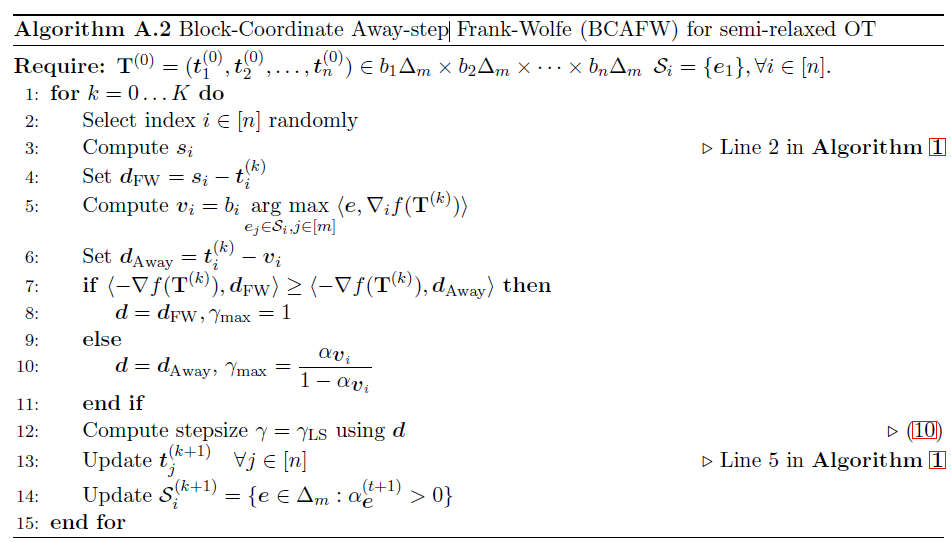

The stepsize is calculated as:
\begin{equation}
\gamma LS = \frac{\lambda \langle d, c_i \rangle + \langle d, T^{(k)}1_n - a \rangle}{|| d ||^2 } 
\end{equation} 

In [22]:
def BlockAwayFrankWolfe(T, C, a, b, K, lambda_c):
  '''
  T: Transport matrix | shape = (m,n)
  C: Cost matrix | shape = (m,n)
  a: mass vector
  b: mass vector
  K: number of iterations
  lambda_c: relaxation parameter
  '''

  def compute_linesearch_BCAFW(T_k, d, c_i, a, K, lambda_c):

    Tk_1n = np.dot(T_k, np.ones(T.shape[1]))
    first_term = np.dot(d, c_i)
    second_term = np.dot(d, (Tk_1n - a))
    numerator = lambda_c*first_term + second_term
    denominator = np.linalg.norm(d, ord = 2)**2
    return -numerator/denominator

  T_k = T.copy()

  first_term_log = []
  second_term_log = []
  f_value_log = []
  time_values = [] 

  start_time = time.time()
  time_values.append(0)
  first_term, second_term, f_value = compute_objective_function(T_k, C, lambda_c, a)
  first_term_log.append(first_term)
  second_term_log.append(second_term)
  f_value_log.append(f_value)


  for k in range(0, K):
    
    i = np.random.randint(low = 0, high = T_k.shape[1], size = 1).item()

    grad_i = C[:,i] + 1/lambda_c * (np.dot(T_k, np.ones(T_k.shape[1])) - a) # m x 1

    # Compute s_i
    index_min = np.argmin(grad_i)
    e_j = np.zeros(shape = T_k.shape[0]) # m x 1
    e_j[index_min] = 1.0
    s_i = np.dot(b[i], e_j) # m x 1

    # Frank-Wolfe direction
    d_FW = s_i - T_k[:,i] # m x 1 
    
    # Compute away vertex
    index_max = np.argmax(grad_i)
    e_j = np.zeros(shape = T_k.shape[0]) # m x 1
    e_j[index_max] = 1.0
    v_i = np.dot(b[i], e_j)

    # Away-Step direction
    d_AW = T_k[:,i] - v_i # m x 1

    #FW step
    if np.dot(-grad_i, d_FW) >= np.dot(-grad_i, d_AW): 
      d = d_FW
      gamma_max = 1 
      # compute the step size
      gamma = min(compute_linesearch_BCAFW(T_k, d, C[:,i], a, K, lambda_c), gamma_max)

    #AWAY step
    else:  
      d = d_AW 
      gamma_max = (v_i[v_i > 0].item()) / (1 - v_i[v_i > 0].item())
      # compute the step size
      gamma = min(compute_linesearch_BCAFW(T_k, d, C[:,i], a, K, lambda_c), gamma_max)

    # Update T_k_i
    T_k[:,i] = (1 - gamma) * T_k[:,i] + gamma * s_i


    first_term, second_term, f_value = compute_objective_function(T_k, C, lambda_c, a)
    time_values.append(time.time() - start_time)
    first_term_log.append(first_term)
    second_term_log.append(second_term)
    f_value_log.append(f_value)


  return T_k, first_term_log, second_term_log, f_value_log, time_values

# Experiments

## Color centroids updating

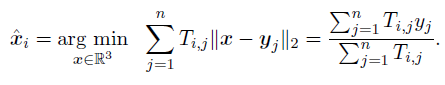

In [23]:
def updated_centroids(T, x, y):
  x_hat = np.zeros(shape = (x.shape[0], x.shape[1])) # m x 3

  for i in range(0, x.shape[0]): # from 0 to m
    numerator = np.zeros(shape = (1, 3)) # 1xdim(y) RGB = 3
    denominator = 0
    for j in range(0, T.shape[1]): # from 0 to n
  
      numerator += T[i,j] * y[j,:]     
      denominator += T[i,j]
    
    x_hat[i,:] = numerator/denominator

  return x_hat.round()

## New color-transformed image

In [24]:
def update_image(x_cluster, x_hat):
  result = np.zeros(shape=(x_cluster.shape[0], 3))
  result[:] = x_hat[x_cluster[:]]
  result = result.reshape(target_img.shape[0], target_img.shape[1], 3).astype(int)

  return result

### Original clustered

In [25]:
i2 = update_image(np.array(x_labels), x_centroids) # original colors but clustered

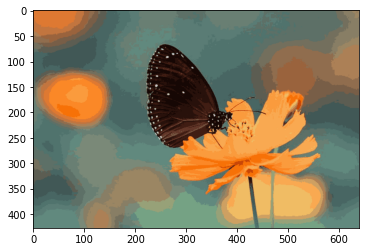

In [26]:
plt.imshow(i2)

### FW

#### $K = 1000$ and $\lambda = 10^{-9}$

In [29]:
T_star_fw_dec_1k_9, first_term_log_fw_dec_1k_9, second_term_log_fw_dec_1k_9, f_value_log_fw_dec_1k_9, \
time_log_fw_dec_1k_9 = FrankWolfe(T_0, C, a, b, K=int(1e3), lambda_c=1e-9, dec=True)

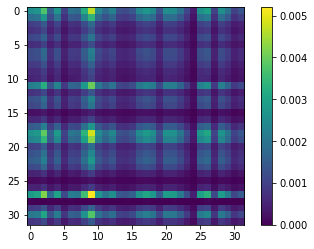

In [30]:
plt.imshow(T_star_fw_dec_1k_9)
plt.colorbar()
plt.show()

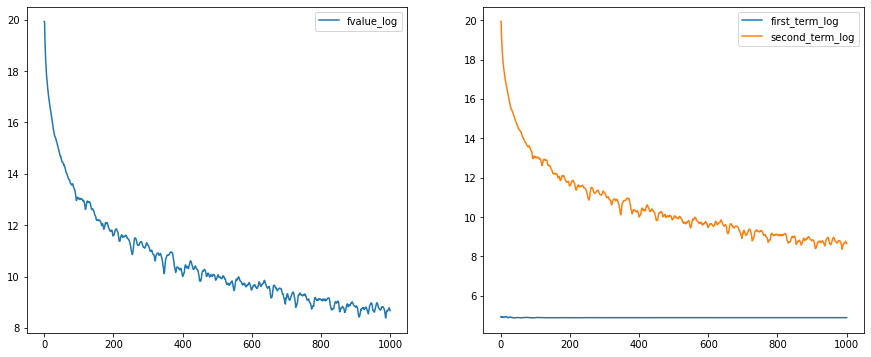

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_fw_dec_1k_9), label='fvalue_log')
ax2.plot(np.log(first_term_log_fw_dec_1k_9), label='first_term_log')
ax2.plot(np.log(second_term_log_fw_dec_1k_9),label='second_term_log')
ax1.legend()
ax2.legend()

In [32]:
x_hat_fw_dec_1k_9 = updated_centroids(T_star_fw_dec_1k_9, x_centroids, y_centroids)

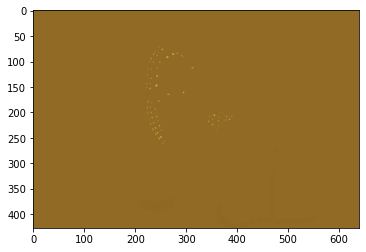

In [33]:
i_fw_dec_1k_9 = update_image(np.array(x_labels), x_hat_fw_dec_1k_9)
plt.imshow(i_fw_dec_1k_9)

#### $K = 10^5$ and $\lambda = 10^{-9}$

In [34]:
T_star_fw_dec_10k5_9, first_term_log_fw_dec_10k5_9, second_term_log_fw_dec_10k5_9, f_value_log_fw_dec_10k5_9, \
time_log_fw_dec_10k5_9 = FrankWolfe(T_0, C, a, b, K=int(10e5), lambda_c=1e-9, dec=True)

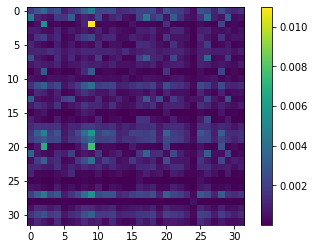

In [35]:
plt.imshow(T_star_fw_dec_10k5_9)
plt.colorbar()
plt.show()

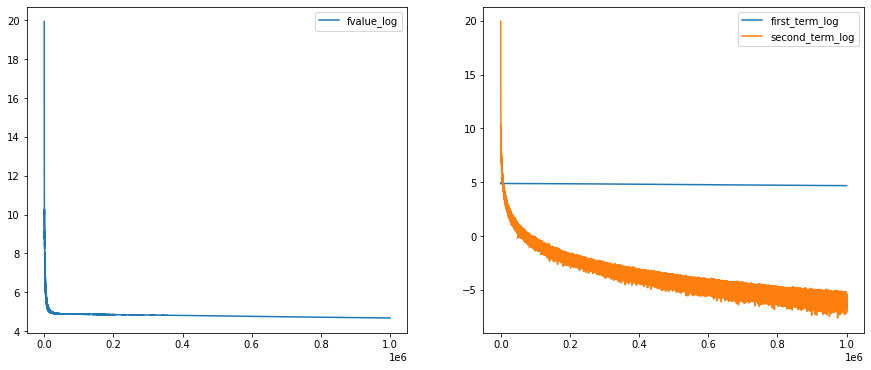

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_fw_dec_10k5_9), label='fvalue_log')
ax2.plot(np.log(first_term_log_fw_dec_10k5_9), label='first_term_log')
ax2.plot(np.log(second_term_log_fw_dec_10k5_9),label='second_term_log')
ax1.legend()
ax2.legend()

In [37]:
x_hat_fw_dec_10k5_9 = updated_centroids(T_star_fw_dec_10k5_9, x_centroids, y_centroids)

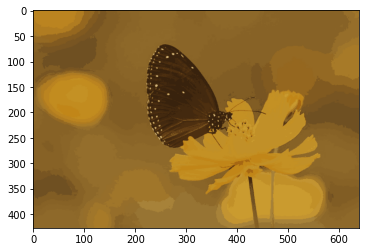

In [38]:
i_fw_dec_10k5_9 = update_image(np.array(x_labels), x_hat_fw_dec_10k5_9)
plt.imshow(i_fw_dec_10k5_9)

#### $K = 1000$ and $\lambda = 10^{-6}$

In [39]:
T_star_fw_dec_1k_6, first_term_log_fw_dec_1k_6, second_term_log_fw_dec_1k_6, f_value_log_fw_dec_1k_6, \
time_log_fw_dec_1k_6 = FrankWolfe(T_0, C, a, b, K=int(1e3), lambda_c=1e-6, dec=True)

Exact line search

In [40]:
T_star_fw_ex_1k_6, first_term_log_fw_ex_1k_6, second_term_log_fw_ex_1k_6, f_value_log_fw_ex_1k_6, \
time_log_fw_ex_1k_6 = FrankWolfe(T_0, C, a, b, K=int(1e3), lambda_c=1e-6, dec=False)

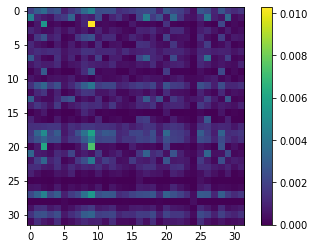

In [41]:
plt.imshow(T_star_fw_dec_1k_6)
plt.colorbar()
plt.show()

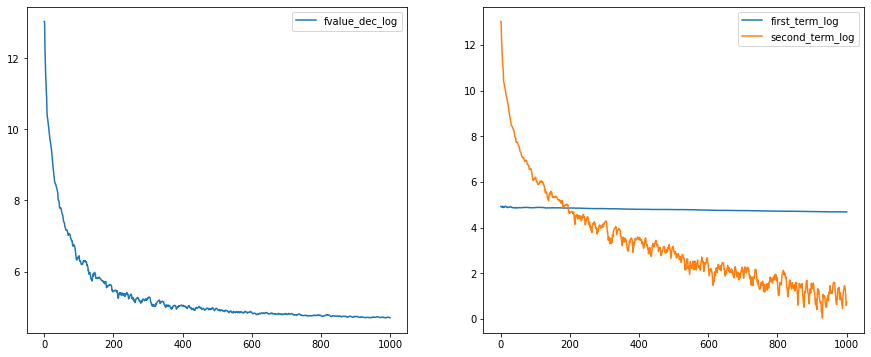

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_fw_dec_1k_6), label='fvalue_dec_log')
ax2.plot(np.log(first_term_log_fw_dec_1k_6), label='first_term_log')
ax2.plot(np.log(second_term_log_fw_dec_1k_6),label='second_term_log')
ax1.legend()
ax2.legend()

In [43]:
x_hat_fw_dec_1k_6 = updated_centroids(T_star_fw_dec_1k_6, x_centroids, y_centroids)

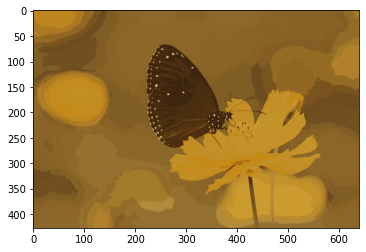

In [44]:
i_fw_dec_1k_6 = update_image(np.array(x_labels), x_hat_fw_dec_1k_6)
plt.imshow(i_fw_dec_1k_6)

#### $K = 10^4$ and $\lambda = 10^{-6}$

In [45]:
T_star_fw_dec_10k4_6, first_term_log_fw_dec_10k4_6, second_term_log_fw_dec_10k4_6, f_value_log_fw_dec_10k4_6, \
time_log_fw_dec_10k4_6 = FrankWolfe(T_0, C, a, b, K=int(10e4), lambda_c=1e-6, dec=True)

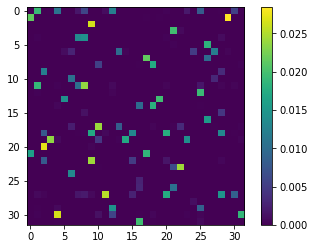

In [46]:
plt.imshow(T_star_fw_dec_10k4_6)
plt.colorbar()
plt.show()

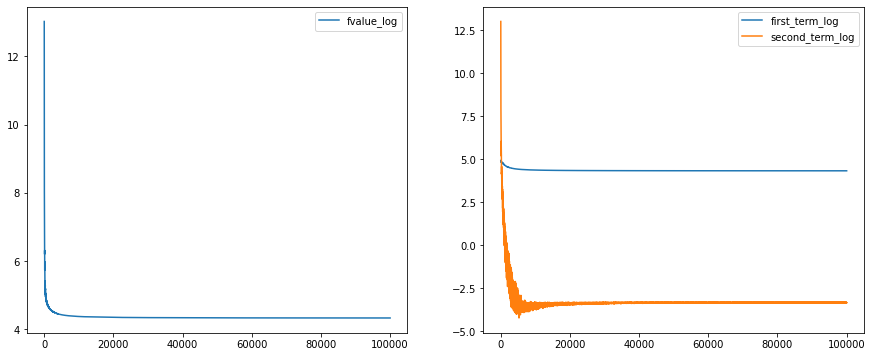

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_fw_dec_10k4_6), label='fvalue_log')
ax2.plot(np.log(first_term_log_fw_dec_10k4_6), label='first_term_log')
ax2.plot(np.log(second_term_log_fw_dec_10k4_6),label='second_term_log')
ax1.legend()
ax2.legend()

In [48]:
x_hat_fw_dec_10k4_6 = updated_centroids(T_star_fw_dec_10k4_6, x_centroids, y_centroids)

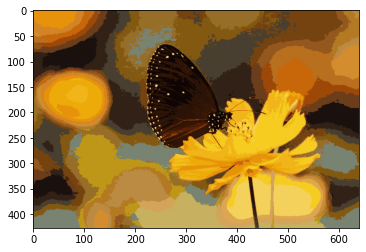

In [49]:
i_fw_dec_10k4_6 = update_image(np.array(x_labels), x_hat_fw_dec_10k4_6)
plt.imshow(i_fw_dec_10k4_6)

###BCFW

#### $K = 1000$ and $\lambda = 10^{-9}$

In [50]:
T_star_bcfw_dec_1k_9, first_term_log_bcfw_dec_1k_9, second_term_log_bcfw_dec_1k_9, f_value_log_bcfw_dec_1k_9, \
time_log_bcfw_dec_1k_9 = BlockFrankWolfe(T_0, C, a, b, K=int(1e3), lambda_c=1e-9, dec=True)

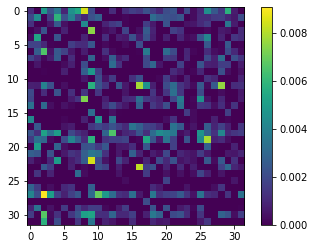

In [51]:
plt.imshow(T_star_bcfw_dec_1k_9)
plt.colorbar()
plt.show()

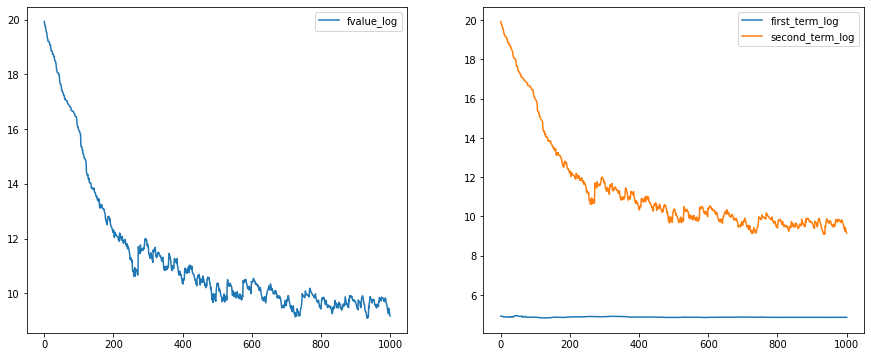

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_bcfw_dec_1k_9), label='fvalue_log')
ax2.plot(np.log(first_term_log_bcfw_dec_1k_9), label='first_term_log')
ax2.plot(np.log(second_term_log_bcfw_dec_1k_9),label='second_term_log')
ax1.legend()
ax2.legend()

In [53]:
x_hat_bcfw_dec_1k_9 = updated_centroids(T_star_bcfw_dec_1k_9, x_centroids, y_centroids)

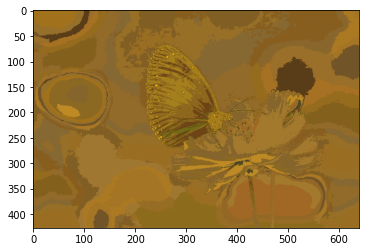

In [54]:
i_bcfw_dec_1k_9 = update_image(np.array(x_labels), x_hat_bcfw_dec_1k_9)
plt.imshow(i_bcfw_dec_1k_9)

#### $K = 10^5$ and $\lambda = 10^{-9}$

In [55]:
T_star_bcfw_dec_10k5_9, first_term_log_bcfw_dec_10k5_9, second_term_log_bcfw_dec_10k5_9, f_value_log_bcfw_dec_10k5_9, \
time_log_bcfw_dec_10k5_9 = BlockFrankWolfe(T_0, C, a, b, K=int(10e5), lambda_c=1e-9, dec=True)

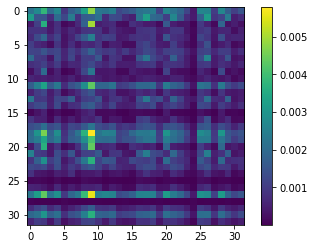

In [56]:
plt.imshow(T_star_bcfw_dec_10k5_9)
plt.colorbar()
plt.show()

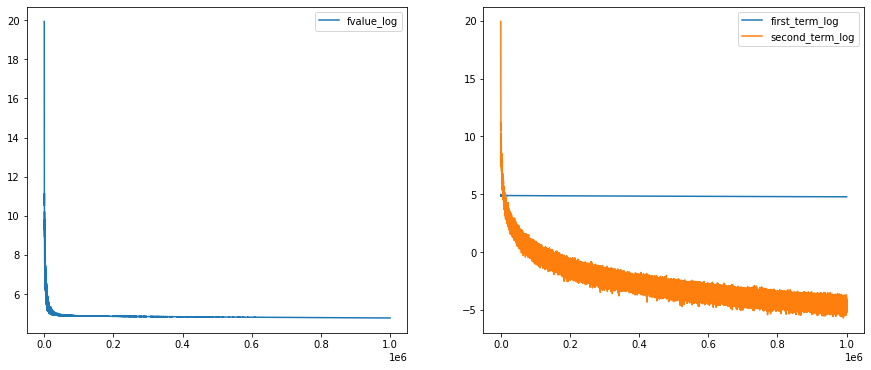

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_bcfw_dec_10k5_9), label='fvalue_log')
ax2.plot(np.log(first_term_log_bcfw_dec_10k5_9), label='first_term_log')
ax2.plot(np.log(second_term_log_bcfw_dec_10k5_9),label='second_term_log')
ax1.legend()
ax2.legend()

In [58]:
x_hat_bcfw_dec_10k5_9 = updated_centroids(T_star_bcfw_dec_10k5_9, x_centroids, y_centroids)

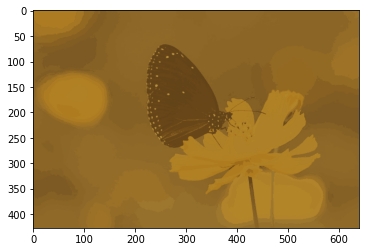

In [59]:
i_bcfw_dec_10k5_9 = update_image(np.array(x_labels), x_hat_bcfw_dec_10k5_9)
plt.imshow(i_bcfw_dec_10k5_9)

#### $K = 1000$ and $\lambda = 10^{-6}$

In [60]:
T_star_bcfw_dec_1k_6, first_term_log_bcfw_dec_1k_6, second_term_log_bcfw_dec_1k_6, f_value_log_bcfw_dec_1k_6, \
time_log_bcfw_dec_1k_6 = BlockFrankWolfe(T_0, C, a, b, K=int(1e3), lambda_c=1e-6, dec=True)

Exact line search

In [61]:
T_star_bcfw_ex_1k_6, first_term_log_bcfw_ex_1k_6, second_term_log_bcfw_ex_1k_6, f_value_log_bcfw_ex_1k_6, \
time_log_bcfw_ex_1k_6 = BlockFrankWolfe(T_0, C, a, b, K=int(1e3), lambda_c=1e-6, dec=False)

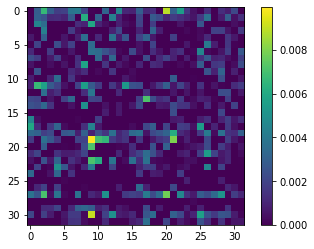

In [62]:
plt.imshow(T_star_bcfw_dec_1k_6)
plt.colorbar()
plt.show()

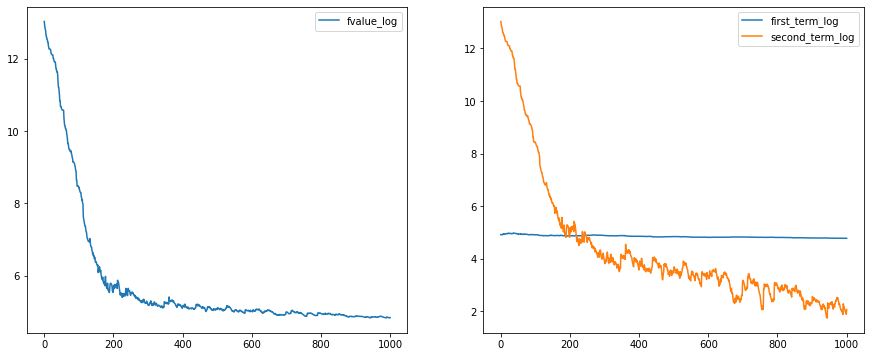

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_bcfw_dec_1k_6), label='fvalue_log')
ax2.plot(np.log(first_term_log_bcfw_dec_1k_6), label='first_term_log')
ax2.plot(np.log(second_term_log_bcfw_dec_1k_6),label='second_term_log')
ax1.legend()
ax2.legend()

In [64]:
x_hat_bcfw_dec_1k_6 = updated_centroids(T_star_bcfw_dec_1k_6, x_centroids, y_centroids)

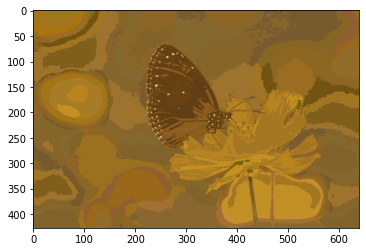

In [65]:
i_bcfw_dec_1k_6 = update_image(np.array(x_labels), x_hat_bcfw_dec_1k_6)
plt.imshow(i_bcfw_dec_1k_6)

#### $K = 10^5$ and $\lambda = 10^{-6}$

In [66]:
T_star_bcfw_dec_10k5_6, first_term_log_bcfw_dec_10k5_6, second_term_log_bcfw_dec_10k5_6, f_value_log_bcfw_dec_10k5_6, \
time_log_bcfw_dec_10k5_6 = BlockFrankWolfe(T_0, C, a, b, K=int(10e5), lambda_c=1e-6, dec=True)

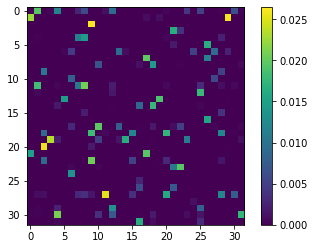

In [67]:
plt.imshow(T_star_bcfw_dec_10k5_6)
plt.colorbar()
plt.show()

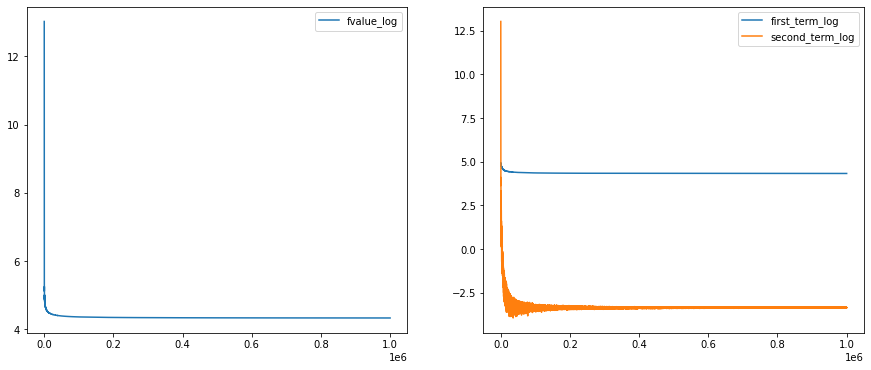

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_bcfw_dec_10k5_6), label='fvalue_log')
ax2.plot(np.log(first_term_log_bcfw_dec_10k5_6), label='first_term_log')
ax2.plot(np.log(second_term_log_bcfw_dec_10k5_6),label='second_term_log')
ax1.legend()
ax2.legend()

In [69]:
x_hat_bcfw_dec_10k5_6 = updated_centroids(T_star_bcfw_dec_10k5_6, x_centroids, y_centroids)

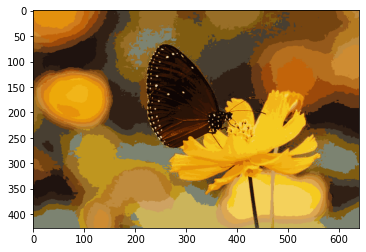

In [70]:
i_bcfw_dec_10k5_6 = update_image(np.array(x_labels), x_hat_bcfw_dec_10k5_6)
plt.imshow(i_bcfw_dec_10k5_6)

### BCAFW

In [71]:
T_star_bcafw, first_term_log_bcafw, second_term_log_bcafw, f_value_log_bcafw, time_log_bcafw = BlockAwayFrankWolfe(T_0, C, a, b, K=int(1e3), lambda_c=1e-6)

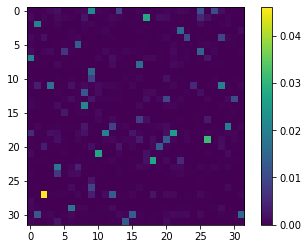

In [72]:
plt.imshow(T_star_bcafw)
plt.colorbar()
plt.show()

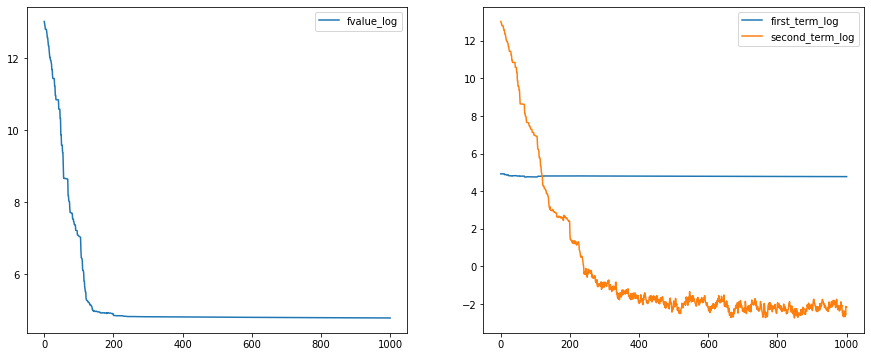

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(np.log(f_value_log_bcafw), label='fvalue_log')
ax2.plot(np.log(first_term_log_bcafw), label='first_term_log')
ax2.plot(np.log(second_term_log_bcafw),label='second_term_log')
ax1.legend()
ax2.legend()

In [74]:
x_hat_bcafw = updated_centroids(T_star_bcafw, x_centroids, y_centroids)

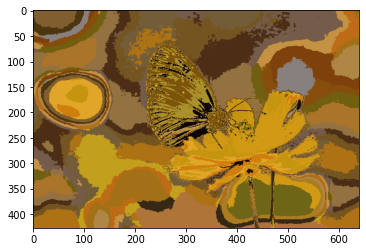

In [75]:
i_bcafw = update_image(np.array(x_labels), x_hat_bcafw)
plt.imshow(i_bcafw)

## Comparison between FW and BCFW

### $K=1000$ and $λ = 10^{-6}$

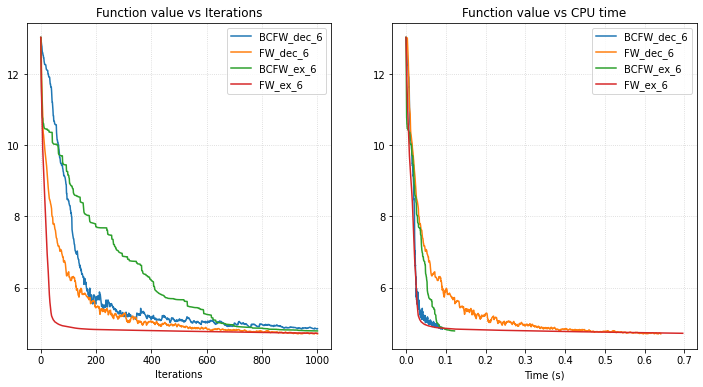

In [76]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title("Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(np.log(f_value_log_bcfw_dec_1k_6), label = 'BCFW_dec_6')
ax1.plot(np.log(f_value_log_fw_dec_1k_6),  label = 'FW_dec_6')
ax1.plot(np.log(f_value_log_bcfw_ex_1k_6),  label = 'BCFW_ex_6')
ax1.plot(np.log(f_value_log_fw_ex_1k_6),  label = 'FW_ex_6')

ax2.plot(time_log_bcfw_dec_1k_6, np.log(f_value_log_bcfw_dec_1k_6), label = 'BCFW_dec_6')
ax2.plot(time_log_fw_dec_1k_6, np.log(f_value_log_fw_dec_1k_6), label = 'FW_dec_6')
ax2.plot(time_log_bcfw_ex_1k_6, np.log(f_value_log_bcfw_ex_1k_6), label = 'BCFW_ex_6')
ax2.plot(time_log_fw_ex_1k_6, np.log(f_value_log_fw_ex_1k_6), label = 'FW_ex_6')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
ax1.legend()
ax2.legend()
fig.show()

### $K=1000$ and $λ = 10^{-9}$

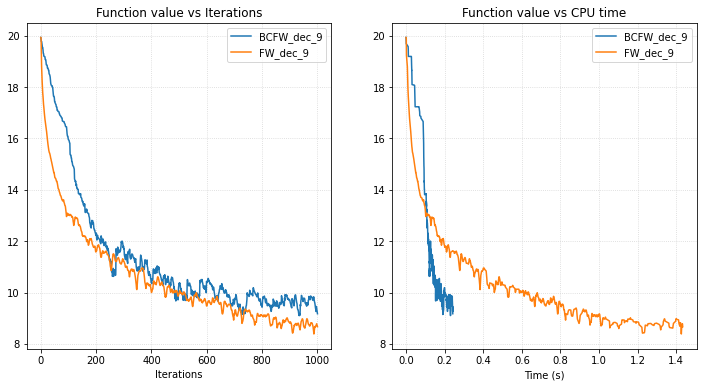

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title("Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(np.log(f_value_log_bcfw_dec_1k_9), label = 'BCFW_dec_9')
ax1.plot(np.log(f_value_log_fw_dec_1k_9),  label = 'FW_dec_9')

ax2.plot(time_log_bcfw_dec_1k_9, np.log(f_value_log_bcfw_dec_1k_9), label = 'BCFW_dec_9')
ax2.plot(time_log_fw_dec_1k_9, np.log(f_value_log_fw_dec_1k_9),  label = 'FW_dec_9')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
ax1.legend()
ax2.legend()
fig.show()

## Comparison of BCFW with different **λ**

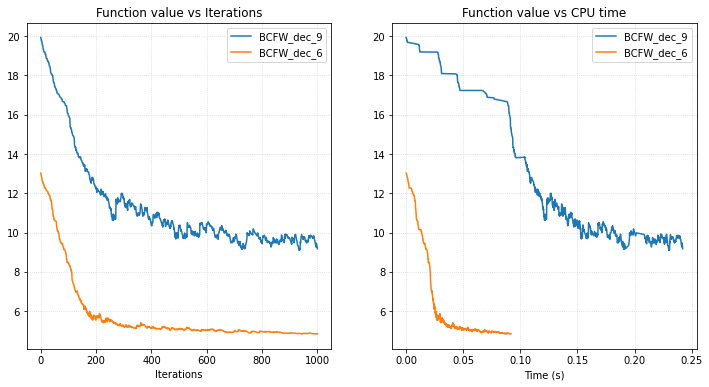

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title("Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(np.log(f_value_log_bcfw_dec_1k_9), label = 'BCFW_dec_9')
ax1.plot(np.log(f_value_log_bcfw_dec_1k_6),  label = 'BCFW_dec_6')

ax2.plot(time_log_bcfw_dec_1k_9, np.log(f_value_log_bcfw_dec_1k_9), label = 'BCFW_dec_9')
ax2.plot(time_log_bcfw_dec_1k_6, np.log(f_value_log_bcfw_dec_1k_6),  label = 'BCFW_dec_6')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
ax1.legend()
ax2.legend()
fig.show()

## Comparison between BCFW and BCAFW

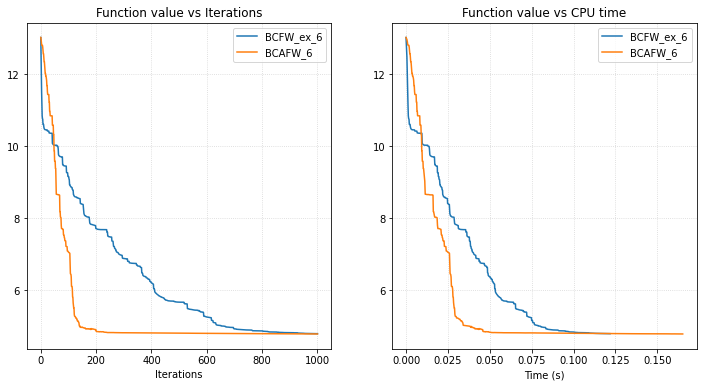

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title("Function value vs Iterations")
ax2.set_title("Function value vs CPU time")
ax1.plot(np.log(f_value_log_bcfw_ex_1k_6), label = 'BCFW_ex_6')
ax1.plot(np.log(f_value_log_bcafw),  label = 'BCAFW_6')

ax2.plot(time_log_bcfw_ex_1k_6, np.log(f_value_log_bcfw_ex_1k_6), label = 'BCFW_ex_6')
ax2.plot(time_log_bcafw, np.log(f_value_log_bcafw),  label = 'BCAFW_6')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')
ax1.set_xlabel("Iterations")
ax2.set_xlabel("Time (s)")
ax1.legend()
ax2.legend()
fig.show()